# Visualize Data

selfie.max(): 248
anime.max(): 1.0
selfie.max(): 249
anime.max(): 1.0
selfie.max(): 255
anime.max(): 1.0
selfie.max(): 255
anime.max(): 1.0
selfie.max(): 255
anime.max(): 1.0
selfie.max(): 255
anime.max(): 1.0


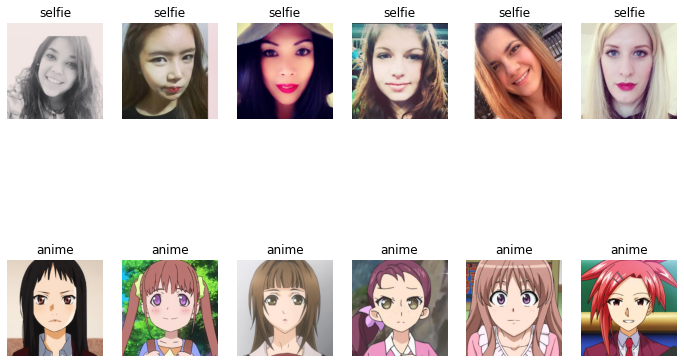

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import os

idxs = [1, 2, 5, 6, 7, 30]
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(12, 8))

# selfie_dir = "data/trainA/"
# anime_dir = "data/trainB/"

selfie_dir = "data/testA/"
anime_dir = "data/testB/"

selfie_files = os.listdir(selfie_dir)
anime_files = os.listdir(anime_dir)


for i, idx in enumerate(idxs):

    selfie = plt.imread(selfie_dir+selfie_files[idx])
    anime = plt.imread(anime_dir+anime_files[idx])

    # print('selfie.shape:', selfie.shape)
    # print('anime.shape:', anime.shape)

    print('selfie.max():', selfie.max())
    print('anime.max():', anime.max())

    axes[0][i].axis('off')
    axes[0][i].imshow(selfie)
    axes[0][i].set_title("selfie")

    axes[1][i].imshow(anime)
    axes[1][i].axis('off')
    axes[1][i].set_title("anime")

# Compute Mean & Std for The Datasets

## Selfie Dataset

In [27]:
from dataset import get_full_list, ImageDataset
import tqdm
from torch.utils.data import DataLoader

selfie_train_list = get_full_list('data', 'trainA')
selfie_train_set = ImageDataset(selfie_train_list)

selfie_train_dl = DataLoader(selfie_train_set, batch_size=100,
                        shuffle=True, num_workers=0)

psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm.tqdm(selfie_train_dl):
    psum    += inputs.sum(axis        = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])


100%|██████████| 34/34 [02:22<00:00,  4.19s/it]


In [28]:
count = len(selfie_train_set) * 256 * 256

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

mean: tensor([0.5636, 0.4678, 0.4462])
std:  tensor([0.3005, 0.2868, 0.2490])


## Anime Dataset

In [29]:
anime_train_list = get_full_list('data', 'trainB')
anime_train_set = ImageDataset(anime_train_list)

anime_train_dl = DataLoader(anime_train_set, batch_size=100,
                        shuffle=True, num_workers=0)

psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm.tqdm(anime_train_dl):
    psum    += inputs.sum(axis        = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

100%|██████████| 34/34 [03:04<00:00,  5.42s/it]


In [30]:
count = len(anime_train_set) * 256 * 256

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

mean: tensor([0.6209, 0.5604, 0.5308])
std:  tensor([0.2886, 0.2771, 0.2695])


# Pass Data to Model

In [6]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.transforms as T
import PIL
from PIL import Image
import numpy as np
import os

USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
using device: cuda


In [2]:
from models import Generator, Discriminator

G = Generator()
D = Discriminator()

G.to(device)
D.to(device)

Discriminator(
  (discriminator_block): Sequential(
    (0): C_K_Block(
      (conv_block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): C_K_Block(
      (conv_block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (2): C_K_Block(
      (conv_block): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (3): C_K_Block(
      (conv_block): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(512, eps=1e-05, momentu

In [40]:
# img = plt.imread('data/testA/female_10328.jpg')
img = Image.open('data/testA/female_10328.jpg')
pix = np.array(img)
convert_tensor = transforms.ToTensor()
img_tensor = convert_tensor(img)
# img_tensor.size()
img_tensor = img_tensor.to(device)

(256, 256, 3)

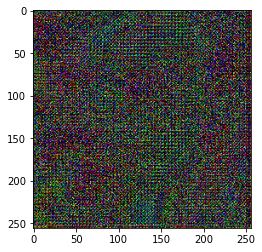

In [41]:
G_out = G(img_tensor.unsqueeze(0))
G_out = G_out.detach().to('cpu').numpy().squeeze().transpose((1,2,0))
plt.imshow((G_out * 255).astype(np.uint8))
G_out.shape

In [42]:
D_out = D(img_tensor.unsqueeze(0))
D_out.size()

torch.Size([1, 1, 30, 30])

# Construct Dataset

In [3]:
%load_ext autoreload
%autoreload 2
from dataset import *

test_A_list = get_full_list('data', 'testA')
test_A_set = ImageDataset(test_A_list)

test_B_list = get_full_list('data', 'testB')
test_B_set = ImageDataset(test_B_list)

S2A_test_set = Selfie2Anime_Dataset(test_A_set, test_B_set)

In [4]:
from torch.utils.data import DataLoader
dataloader = DataLoader(S2A_test_set, batch_size=1,
                        shuffle=True, num_workers=0)

In [10]:
%load_ext autoreload
%autoreload 2
from CycleGAN import CycleGAN

model = CycleGAN(use_cuda=True)

model.set_mode_train()

for i, samples in enumerate(dataloader):
    selfie_images, anime_images = samples
    
    model.set_input_images(selfie_images.to(device), anime_images.to(device))
    model.update_gradient_G()
    model.update_gradient_D()

    print('sample:', i)
    print("G loss:", model.loss_G)
    print("D1 loss:", model.loss_D1)
    print("D2 loss:", model.loss_D2)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
device for CycleGAN: cuda
sample: 0
G loss: 25.415376663208008
D1 loss: 2.155357837677002
D2 loss: 1.4778071641921997
sample: 1
G loss: 45.86957550048828
D1 loss: 11.488834381103516
D2 loss: 13.399986267089844
sample: 2
G loss: 33.490901947021484
D1 loss: 2.9244444370269775
D2 loss: 1.9350521564483643
sample: 3
G loss: 30.73031234741211
D1 loss: 1.491159200668335
D2 loss: 3.796186685562134
sample: 4
G loss: 34.70405578613281
D1 loss: 1.6701090335845947
D2 loss: 2.7736167907714844
sample: 5
G loss: 27.500154495239258
D1 loss: 1.2465159893035889
D2 loss: 1.5996572971343994
sample: 6
G loss: 27.06148910522461
D1 loss: 1.0023412704467773
D2 loss: 2.5620312690734863
sample: 7
G loss: 28.68280601501465
D1 loss: 0.8586841821670532
D2 loss: 1.946040391921997
sample: 8
G loss: 27.51990509033203
D1 loss: 1.1823382377624512
D2 loss: 1.53294837474823
sample: 9
G loss: 25.4146671295166
D1 loss: 1.056411743164062

In [11]:
model.set_mode_eval()

selfie_images, anime_images = S2A_test_set[4]
selfie_images = selfie_images.unsqueeze(0)
anime_images = anime_images.unsqueeze(0)
    
model.set_input_images(selfie_images.to(device), anime_images.to(device))
model.test()

In [12]:
model.save("checkpoints/test_save_ep1.pt", 1)

In [13]:
model_2 = CycleGAN(use_cuda=True)
model_2.load("checkpoints/test_save_ep1.pt")


device for CycleGAN: cuda


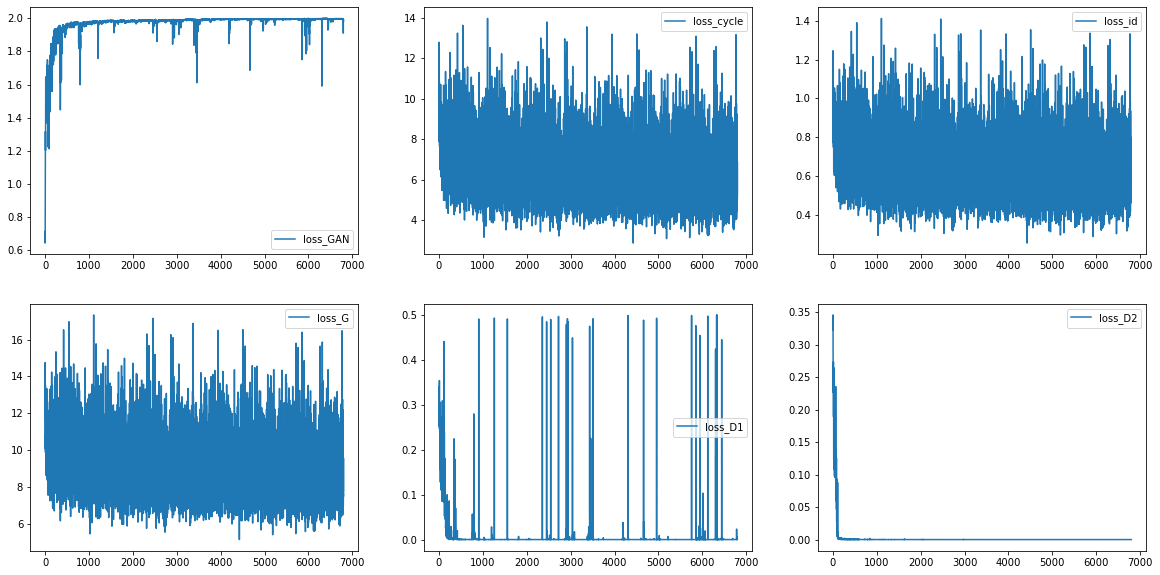

In [8]:
import pickle
import matplotlib.pyplot as plt
with open("training_results/default_train_losses.pickle", "rb") as f:
    loss_history = pickle.load(f) 

len(loss_history['loss_G'])

fig, ax = plt.subplots(2,3,figsize=(20,10))

ax[0][0].plot(loss_history['loss_GAN'], label="loss_GAN")
ax[0][1].plot(loss_history['loss_cycle'], label="loss_cycle")
ax[0][2].plot(loss_history['loss_id'], label="loss_id")

ax[1][0].plot(loss_history['loss_G'], label="loss_G")
ax[1][1].plot(loss_history['loss_D1'], label="loss_D1")
ax[1][2].plot(loss_history['loss_D2'], label="loss_D2")

for i in range(2):
    for j in range(3):
        ax[i][j].legend()



device for CycleGAN: cuda
rec_anime.max() 1.0
original_anime.max() 1.0
rec_selfie.max() 1.0


Text(0.5, 1.0, 'Reconstructed Anime')

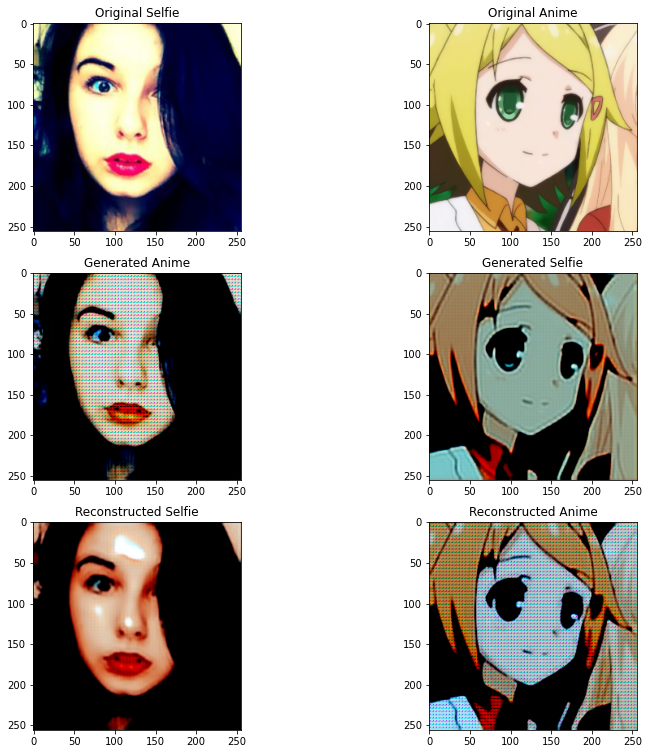

In [9]:
def normalize_image(image):
    image = image - np.min(image)
    image = image / np.max(image)

    return image

from CycleGAN import CycleGAN
model = CycleGAN(use_cuda=True)
model.load("checkpoints/default_train_ep2.pt")

model.set_mode_eval()

selfie_image, anime_image = S2A_test_set[30]
selfie_image = selfie_image.unsqueeze(0)
anime_image = anime_image.unsqueeze(0)
    
model.set_input_images(selfie_image.to(device), anime_image.to(device))
model.test()

original_selfie = selfie_image.detach().to('cpu').numpy().squeeze().transpose((1,2,0))
original_anime = anime_image.detach().to('cpu').numpy().squeeze().transpose((1,2,0))

generated_selfie = model.fake_img_1.detach().to('cpu').numpy().squeeze().transpose((1,2,0))
generated_anime = model.fake_img_2.detach().to('cpu').numpy().squeeze().transpose((1,2,0))

rec_selfie = model.rec_img_1.detach().to('cpu').numpy().squeeze().transpose((1,2,0))
rec_anime = model.rec_img_2.detach().to('cpu').numpy().squeeze().transpose((1,2,0))

original_selfie = normalize_image(original_selfie)
original_anime = normalize_image(original_anime)
generated_selfie = normalize_image(generated_selfie)
generated_anime = normalize_image(generated_anime)
rec_selfie = normalize_image(rec_selfie)
rec_anime = normalize_image(rec_anime)

print("rec_anime.max()", rec_anime.max())
print("original_anime.max()", original_anime.max())
print("rec_selfie.max()", rec_selfie.max())



fig, ax = plt.subplots(3,2,figsize=(13,13))
ax[0][0].imshow((original_selfie*255).astype(np.uint8))
ax[0][0].set_title('Original Selfie')
ax[0][1].imshow((original_anime*255).astype(np.uint8))
ax[0][1].set_title('Original Anime')

ax[1][0].imshow((generated_anime*255).astype(np.uint8))
ax[1][0].set_title('Generated Anime')
ax[1][1].imshow((generated_selfie*255).astype(np.uint8))
ax[1][1].set_title('Generated Selfie')

ax[2][0].imshow((rec_selfie*255).astype(np.uint8))
ax[2][0].set_title('Reconstructed Selfie')
ax[2][1].imshow((rec_anime*255).astype(np.uint8))
ax[2][1].set_title('Reconstructed Anime')

